# papers
# https://arxiv.org/pdf/2010.11929.pdf
# https://arxiv.org/pdf/1706.03762.pdf

# comments
# Adapted from: https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py#L29

In [1]:
! pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
# tensor manipulation library for reshaping, permuting and composing tensors
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop, Grayscale, ColorJitter
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
# track the progress of code's execution
from tqdm.notebook import tqdm, trange
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from google.colab import drive
from PIL import Image
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

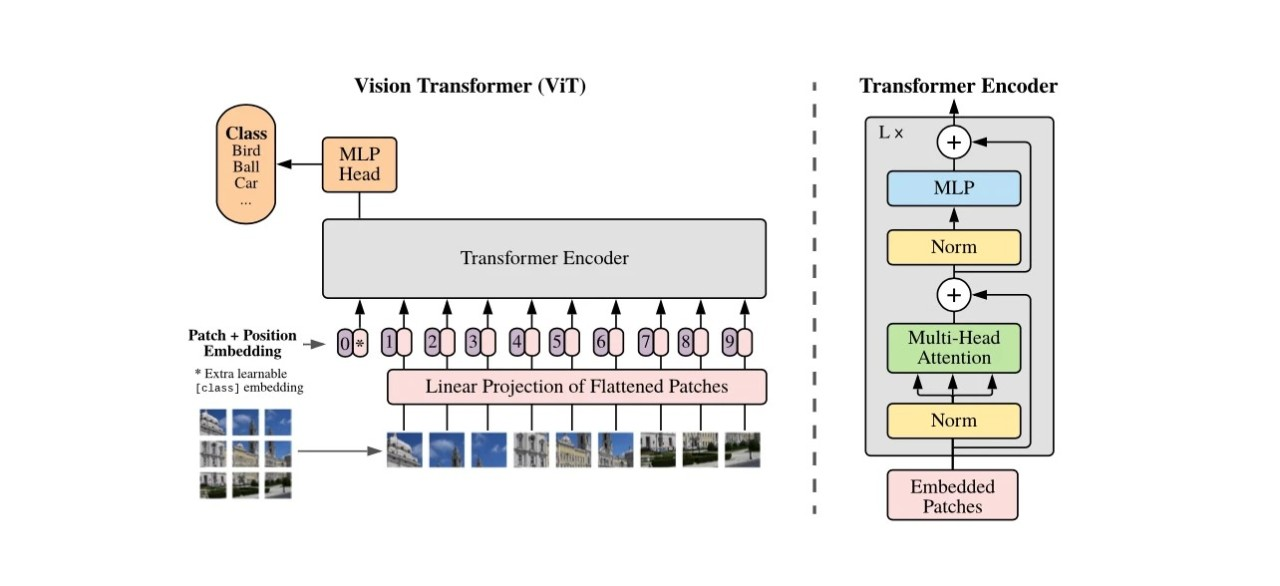

In [3]:
class PatchEmbedding(nn.Module):
    # these parameters define the processing steps for converting an input image into a sequence of patches,
    # projecting them into an embedding space, and adding positional embeddings
    # input image = 224x224 pixels
    # n_channels=3 ->RGB images
    # patch_size = 16x16 pixels
    # each patch will be transformed into a vector of size 768
    def __init__(self, img_size=224, n_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size * n_channels
        # define a sequence of operations to project the image patches into an embedding space
        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            # 1, 3, 224, 224 -> 1, 3, 14x16, 14x16 -> 1, 14x14, 16x16x3
            # layer normalization
            nn.LayerNorm(patch_dim),
            # project the patches into a lower-dimensional embedding space
            nn.Linear(patch_dim, embedding_dim),
            # another layer normalization
            nn.LayerNorm(embedding_dim)
        )
        # generates a random 3D tensor with values sampled from a uniform distribution between 0 and 1,
        # then converts the tensor into a learnable parameter
        self.cls_token = nn.Parameter(torch.rand((1, 1, embedding_dim)))
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        # initializes learnable positional embeddings for each patch, including an extra positional embedding for the "class" token
        self.pos_embedding = nn.Parameter(torch.rand((num_patches + 1, embedding_dim)))

    # prepares the input image for processing by a transformer-based model by projecting image patches into an embedding space,
    # adding a class token, and including positional embeddings.
    def forward(self, x):
        # extract the batch size from input
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        return x

In [4]:
# defines a simple feedforward network with layer normalization, linear transformations, GELU activation, and dropout.
class FeedForward(nn.Module):
    # dropout: regularization technique used to prevent overfitting
    def __init__(self, embedding_dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, hidden_dim),
            # non-linear activation function: Gaussian Error Linear Unit
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embedding_dim),
        )

    def forward(self, x):
        return self.net(x)

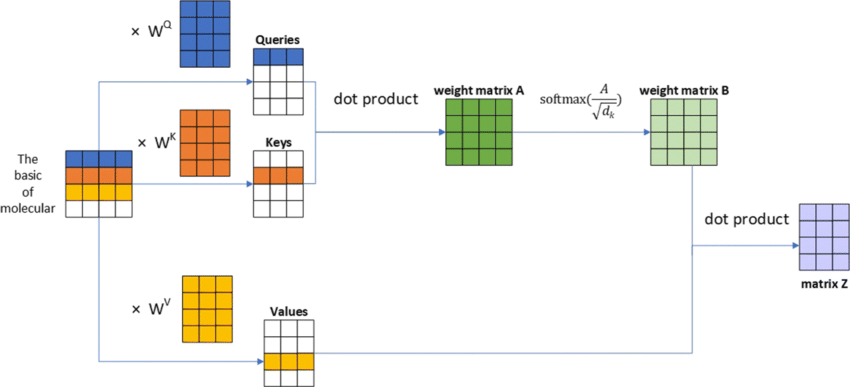

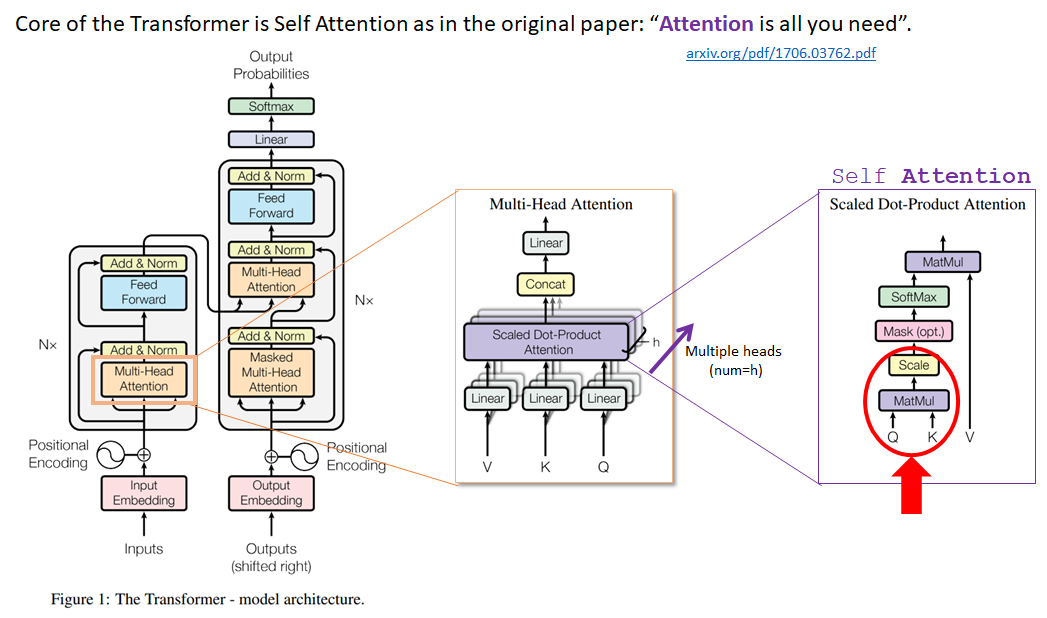

In [5]:
# Multi-head attention and self attention
class Attention(nn.Module):
    # parameters: dim: dimension of the input, heads:number of attention heads, dim_head:dimension of each attention head
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        # calculates the total dimensionality of the query, key, and value vectors after splitting them into heads
        inner_dim = dim_head *  heads
        # determines whether a projection is needed at the output.
        # If heads == 1 and dim_head == dim, no projection is needed, and an nn.Identity() layer is used instead.
        # nn.Identity() is used to handle this special case, as it simply returns the input tensor unchanged
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        # it is used to scale the dot product of the query and key vectors before applying the softmax function
        # 1. prevent the gradients from becoming too small, which can help stabilize the training process.
        # 2. we ensure that the attention scores are more evenly distributed, allowing the model to attend to multiple parts of the input sequence effectively
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        # Specifying dim=-1 ensures that the softmax function is applied independently to each row of the input tensor.
        # ensure that the attention scores for each query position are normalized to sum up to 1
        # it is crucial for correctly computing the attention weights in the transformer's attention mechanism,
        # ensuring that the weights are computed independently for each query position
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        # projects the input tensor x into query, key, and value vectors
        # inner_dim * 3 because we need three sets of vectors for query, key, and value.
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        # identity function: no operation
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        # chunk(3, dim = -1): splits them into three tensors along the last dimension (dim=-1).
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        # reshaped from [batch_size, num_patches, inner_dim] to [batch_size, num_heads, num_patches, head_dim]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        # print(f"q.shape={q.shape}, k.shape={k.shape}, v.shape={v.shape}")

        # performs matrix multiplication between the query tensor and key tensor
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        # print(f"dot.shape={dots.shape}")

        # applies the softmax function to the attention scores to get the attention weights
        attn = self.attend(dots)
        attn = self.dropout(attn)

        # print(f"atten.shape={attn.shape}, v.shape={v.shape}")
        # calculates the weighted sum of the value vectors v using the attention weights
        out = torch.matmul(attn, v)
        # print(f"out.shape={out.shape}")
        # reshaped from [batch_size, num_heads, num_patches, head_dim] back to [batch_size, num_patches, inner_dim]
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

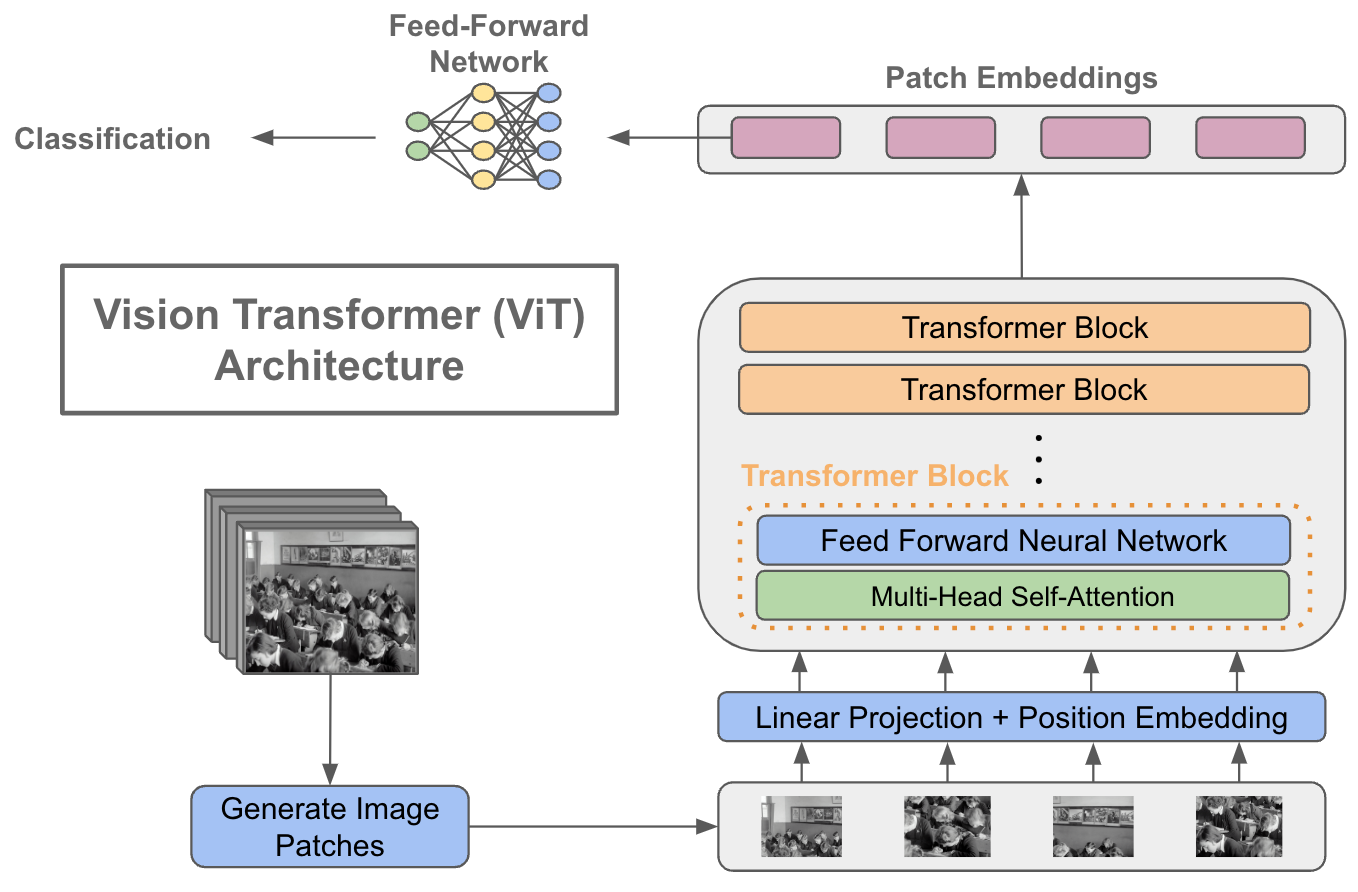

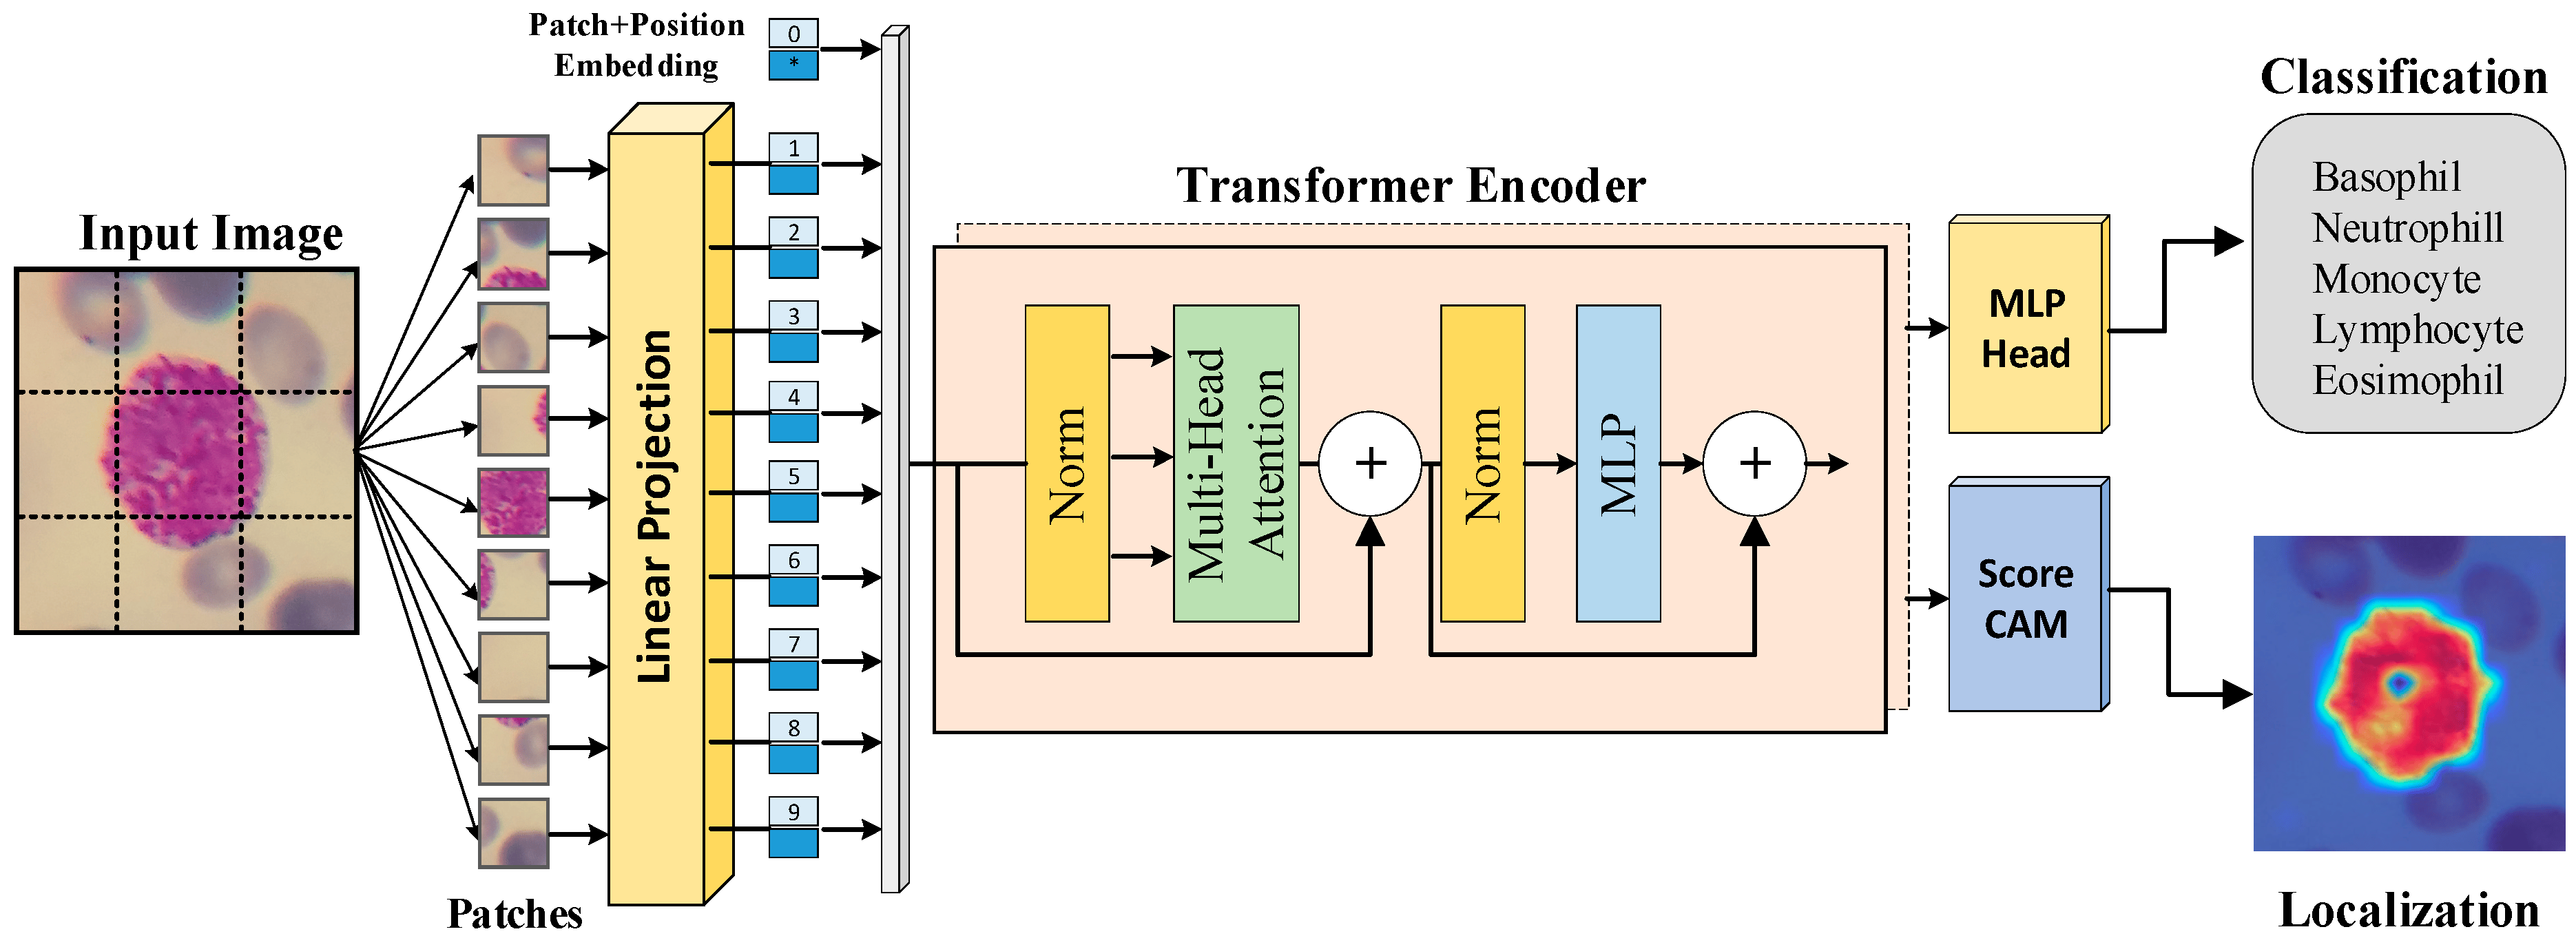

In [6]:
class TransformerEncoderBlock(nn.Module):
    # embedding_dim: dimensionality of the input embeddings, hidden_dim: dimensionality of the hidden layer in the feedforward network
    def __init__(self, embedding_dim, hidden_dim, n_heads=8, dropout=0.):
        super().__init__()
        self.attn_norm = nn.LayerNorm(embedding_dim)
        # computes the attention weights and applies the attention mechanism
        self.attention = Attention(dim=embedding_dim, heads=n_heads, dim_head=hidden_dim // embedding_dim, dropout=dropout)
        # applies a feedforward network to the output of the attention mechanism
        self.ffn = FeedForward(embedding_dim=embedding_dim, hidden_dim=hidden_dim, dropout=dropout)

    def forward(self, x):
        x_norm = self.attn_norm(x)
        # introduces the concept of residual connections, which help with gradient flow and alleviate the vanishing gradient problem.
        x = self.attention(x_norm) + x
        # uses a residual connection to maintain information flow through the network
        x = self.ffn(x) + x
        return x

In [7]:
class ViT(nn.Module):
    def __init__(self, image_size, n_channels, patch_size, num_classes,
                 embedding_dim, hidden_dim, num_encoders, num_heads, dropout=0.):
        super().__init__()
        # converts image patches into embeddings
        self.patch_embedding = PatchEmbedding(image_size, n_channels, patch_size, embedding_dim)
        # process the embeddings using attention and feedforward networks
        self.encoders = nn.ModuleList([
            TransformerEncoderBlock(
                embedding_dim=embedding_dim, hidden_dim=hidden_dim, n_heads=num_heads, dropout=dropout
            ) for i in range(num_encoders)
        ])

        # maps the final embedding dimension to the number of classes for classification
        self.head = nn.Linear(embedding_dim, num_classes)

    def forward(self, image):
        # converts the input image into patches and embeds them
        x = self.patch_embedding(image)
        # passes the embedded patches through each transformer encoder block, and apply attention and feedforward
        for block in self.encoders:
            x = block(x)

        # pooling
        # select the class token for classification, because this token represent the entire image
        x = x[:, 0]
        #  average
        # x = x.mean(dim=1)

        # obtain the final logits for the classification task
        return self.head(x)

In [ ]:
# test whether the model works
# x = torch.rand((2, 3, 224, 224))
# model = ViT(image_size=224, n_channels=3, patch_size=16, num_classes=7,
#             embedding_dim=768, hidden_dim=49_152, num_encoders=6, num_heads=12, dropout=0.1)
# pred = model(x)
# print(pred)

tensor([[-1.3810,  0.5456,  0.1465,  0.3330,  1.3050,  0.3418, -0.0678],
        [-1.3375,  0.5312,  0.1360,  0.6339,  1.5940,  0.2998, -0.0456]],
       grad_fn=<AddmmBackward0>)


In [8]:
drive.mount('/content/drive')
datafolder = 'fer2013'
dir = f'./drive/MyDrive/CS5100_Project_FacialEmotion_Lili/{datafolder}'

Mounted at /content/drive


## upload dataset folder and unzip the folder and move to our directory

In [9]:
 !unzip -q './drive/MyDrive/CS5100_Project_FacialEmotion_Lili/fer2013.zip'

In [ ]:
# !mv ./fer2013 ./drive/MyDrive/CS5100_Project_FacialEmotion_Lili/

## Data loader

In [10]:
# parameters
data_dir_root = "./fer2013"
n_channels = 1
batch_size = 64

# creates a transformation pipeline
train_transform = Compose([
    Grayscale(num_output_channels=n_channels),
    # Resize(224),
    ToTensor(),
])

# ImageFolder returns a dataset object that can be directly passed to a DataLoade
train_data = ImageFolder(root=f"{data_dir_root}/train", transform=train_transform)
test_data = ImageFolder(root=f"{data_dir_root}/test", transform=train_transform)

# number of subprocesses set to 4
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, drop_last=True)

print(f"Train data len={len(train_data)}, test data len={len(test_data)}")

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}, dtype: {train_features.dtype}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(f"Label: {label}")

Train data len=28709, test data len=7178


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Feature batch shape: torch.Size([64, 1, 48, 48]), dtype: torch.float32
Labels batch shape: torch.Size([64])
Label: 3


## Training loop

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# define parameters
image_size = 48
patch_size = 8
num_classes=7
embedding_dim = 768
num_encoders = 12
num_heads = 12
dropout = 0.1

model = ViT(image_size=image_size, n_channels=n_channels, patch_size=patch_size, num_classes=num_classes,
        embedding_dim=embedding_dim, hidden_dim=embedding_dim*4, num_encoders=num_encoders,
        num_heads=num_heads, dropout=dropout)
model = model.to(device)
params_has_grad = [n for n, p in model.named_parameters() if p.requires_grad]
print(f"model num. layers={len(params_has_grad)}")

Using device:  cuda (Tesla T4)
model num. layers=166


In [ ]:
def main():
   # Loading data
    # because PyTorch operates primarily on tensors, so converting input data (images) into PyTorch tensors is necessary
    # also converting input images to PyTorch tensors is essential for efficient computation and gradient calculation in neural network training
    transform = ToTensor()

    # Shuffling the data helps in preventing the model from learning the order of the training examples,
    # which can be beneficial for the model's generalization
    # train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    # batch size of 128 means that the model will process 128 samples at a time before updating the weights.
    # test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    N_EPOCHS = 15
    LR = 2e-4

    # define checkpoint_dir
    checkpoint_dir = './drive/MyDrive/CS5100_Project_FacialEmotion_Lili/checkpoint'

    out_dir = Path(checkpoint_dir)
    out_dir.mkdir(exist_ok=True)

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    # loss function
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        model.train()
        for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False)):
            optimizer.zero_grad()

            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            #train_loss_step = loss.detach().cpu().item() / len(train_dataloader)
            train_loss += loss.detach().cpu().item()
            #print(f"train-loss={train_loss:.4f} (step-{step}={train_loss_step:.4f})")

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss / len(train_dataloader):.2f}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            }, out_dir / f"ckpt_epoch_{epoch}.pth")

        # evaluation
        correct = 0
        total = 0
        model.eval()
        for data in tqdm(test_dataloader):
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.detach().cpu()
            # print(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'  validation accuracy: {100 * correct // total} %')



In [ ]:
main()

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 1/15 loss: 2.05


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 30 %


Epoch 2 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 2/15 loss: 1.71


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 34 %


Epoch 3 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 3/15 loss: 1.62


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 37 %


Epoch 4 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 4/15 loss: 1.54


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 40 %


Epoch 5 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 5/15 loss: 1.48


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 40 %


Epoch 6 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 6/15 loss: 1.42


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 41 %


Epoch 7 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 7/15 loss: 1.33


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 42 %


Epoch 8 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 8/15 loss: 1.24


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 41 %


Epoch 9 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 9/15 loss: 1.13


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 42 %


Epoch 10 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 10/15 loss: 1.00


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 43 %


Epoch 11 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 11/15 loss: 0.85


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 45 %


Epoch 12 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 12/15 loss: 0.69


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 43 %


Epoch 13 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 13/15 loss: 0.53


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 44 %


Epoch 14 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 14/15 loss: 0.44


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 44 %


Epoch 15 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 15/15 loss: 0.35


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 44 %


### Adjust the parameters and perform data augmentation
### 1. Increase the number of encoders to 12, and the number of heads to 12
### 2. Data augmentation: horizontal filp, and adjust the brightness of the images
### 3. Add lr_scheduler.OneCycleLR and train 20 epochs

In [ ]:
# define parameters
image_size = 48
patch_size = 8
num_classes=7
embedding_dim = 768
num_encoders = 12
num_heads = 12
dropout = 0.1

In [ ]:
train_transform = Compose([
    Grayscale(num_output_channels=n_channels),
    Resize(image_size),
    RandomHorizontalFlip(),
    ColorJitter(brightness=[0.9, 1.2], contrast=0.1),
    ToTensor(),
])

val_transform = Compose([
    Grayscale(num_output_channels=n_channels),
    Resize(image_size),
    ToTensor(),
])

train_data = ImageFolder(root=f"{data_dir_root}/train", transform=train_transform)
test_data = ImageFolder(root=f"{data_dir_root}/test", transform=val_transform)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")


model = ViT(image_size=image_size, n_channels=n_channels, patch_size=patch_size, num_classes=num_classes,
        embedding_dim=embedding_dim, hidden_dim=embedding_dim*4, num_encoders=num_encoders,
        num_heads=num_heads, dropout=dropout)
model = model.to(device)
params_has_grad = [n for n, p in model.named_parameters() if p.requires_grad]
print(f"model num. layers={len(params_has_grad)}")

Using device:  cuda (Tesla T4)
model num. layers=166


In [ ]:
def main():
   # Loading data
    # because PyTorch operates primarily on tensors, so converting input data (images) into PyTorch tensors is necessary
    # also converting input images to PyTorch tensors is essential for efficient computation and gradient calculation in neural network training
    transform = ToTensor()

    # Defining model and training options
    N_EPOCHS = 20
    LR = 2e-4

    # define checkpoint_dir
    checkpoint_dir = './drive/MyDrive/CS5100_Project_FacialEmotion_Lili/checkpoint'

    out_dir = Path(checkpoint_dir)
    out_dir.mkdir(exist_ok=True)

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    # loss function
    criterion = CrossEntropyLoss()
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                        steps_per_epoch=len(train_dataloader), epochs=N_EPOCHS)

    best_acc = 0.0
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        print(f"LR={optimizer.state_dict()['param_groups'][0]['lr']:.6f}")
        model.train()
        for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False)):
            optimizer.zero_grad()

            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            #train_loss_step = loss.detach().cpu().item() / len(train_dataloader)
            train_loss += loss.detach().cpu().item()
            #print(f"train-loss={train_loss:.4f} (step-{step}={train_loss_step:.4f})")

            loss.backward()
            optimizer.step()
            scheduler.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss / len(train_dataloader):.2f}")

        # evaluation
        correct = 0
        total = 0
        model.eval()
        for data in tqdm(test_dataloader):
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.detach().cpu()
            # print(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        print(f'  validation accuracy: {test_acc:.2f} %')

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, out_dir / f"ckpt_best.pth")

In [ ]:
main()

Training:   0%|          | 0/20 [00:00<?, ?it/s]

LR=0.000008


Epoch 1 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 1/20 loss: 1.84


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 21.96 %
LR=0.000021


Epoch 2 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 2/20 loss: 1.74


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 34.18 %
LR=0.000056


Epoch 3 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 3/20 loss: 1.64


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 34.82 %
LR=0.000104


Epoch 4 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 4/20 loss: 1.58


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 38.45 %
LR=0.000152


Epoch 5 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 5/20 loss: 1.53


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 34.50 %
LR=0.000187


Epoch 6 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 6/20 loss: 1.45


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 39.87 %
LR=0.000200


Epoch 7 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 7/20 loss: 1.36


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 45.13 %
LR=0.000197


Epoch 8 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 8/20 loss: 1.23


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 44.42 %
LR=0.000190


Epoch 9 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 9/20 loss: 1.10


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 44.55 %
LR=0.000178


Epoch 10 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 10/20 loss: 0.90


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 45.35 %
LR=0.000162


Epoch 11 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 11/20 loss: 0.66


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 48.13 %
LR=0.000143


Epoch 12 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 12/20 loss: 0.40


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 47.35 %
LR=0.000122


Epoch 13 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 13/20 loss: 0.21


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 47.74 %
LR=0.000100


Epoch 14 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 14/20 loss: 0.12


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 48.74 %
LR=0.000078


Epoch 15 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 15/20 loss: 0.07


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 49.22 %
LR=0.000057


Epoch 16 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 16/20 loss: 0.04


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 48.81 %
LR=0.000038


Epoch 17 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 17/20 loss: 0.02


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 49.11 %
LR=0.000022


Epoch 18 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 18/20 loss: 0.02


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 49.32 %
LR=0.000010


Epoch 19 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 19/20 loss: 0.01


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 49.08 %
LR=0.000002


Epoch 20 in training:   0%|          | 0/448 [00:00<?, ?it/s]

Epoch 20/20 loss: 0.01


  0%|          | 0/112 [00:00<?, ?it/s]

  validation accuracy: 49.15 %


## Evaluation for selected model

### For checkpoint ckpt_epoch_4_6e_8h.pth: 6 encoders and 8 heads

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# define parameters
image_size = 48
patch_size = 8
num_classes=7
embedding_dim = 768
num_encoders = 6
num_heads = 8
dropout = 0.1

model = ViT(image_size=image_size, n_channels=n_channels, patch_size=patch_size, num_classes=num_classes,
        embedding_dim=embedding_dim, hidden_dim=embedding_dim*4, num_encoders=num_encoders,
        num_heads=num_heads, dropout=dropout)
model = model.to(device)
params_has_grad = [n for n, p in model.named_parameters() if p.requires_grad]
print(f"model num. layers={len(params_has_grad)}")

Using device:  cpu 
model num. layers=88


In [ ]:
checkpoint = torch.load("./drive/MyDrive/CS5100_Project_FacialEmotion_Lili/checkpoint/ckpt_epoch_4_6e_8h.pth", map_location='cpu')
print(checkpoint.keys())

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(test_dataloader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.detach().cpu()
        # print(predicted, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy: 45 %


### For checkpoint ckpt_epoch_10_12_12_2e_15epoch.pth: 12 encoders and 12 heads

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# define parameters
image_size = 48
patch_size = 8
num_classes=7
embedding_dim = 768
num_encoders = 12
num_heads = 12
dropout = 0.1

model = ViT(image_size=image_size, n_channels=n_channels, patch_size=patch_size, num_classes=num_classes,
        embedding_dim=embedding_dim, hidden_dim=embedding_dim*4, num_encoders=num_encoders,
        num_heads=num_heads, dropout=dropout)
model = model.to(device)
params_has_grad = [n for n, p in model.named_parameters() if p.requires_grad]
print(f"model num. layers={len(params_has_grad)}")

Using device:  cpu 
model num. layers=166


In [ ]:
checkpoint = torch.load("./drive/MyDrive/CS5100_Project_FacialEmotion_Lili/checkpoint/ckpt_epoch_10_12_12_2e_15epoch.pth", map_location='cpu')
print(checkpoint.keys())

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(test_dataloader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.detach().cpu()
        # print(predicted, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy: 45 %


### For checkpoint ckpt_best.pth: 12 encoders and 12 heads

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# define parameters
image_size = 48
patch_size = 8
num_classes=7
embedding_dim = 768
num_encoders = 12
num_heads = 12
dropout = 0.1

model = ViT(image_size=image_size, n_channels=n_channels, patch_size=patch_size, num_classes=num_classes,
        embedding_dim=embedding_dim, hidden_dim=embedding_dim*4, num_encoders=num_encoders,
        num_heads=num_heads, dropout=dropout)
model = model.to(device)
params_has_grad = [n for n, p in model.named_parameters() if p.requires_grad]
print(f"model num. layers={len(params_has_grad)}")

Using device:  cpu 
model num. layers=166


In [ ]:
checkpoint = torch.load("./drive/MyDrive/CS5100_Project_FacialEmotion_Lili/checkpoint/ckpt_best.pth", map_location='cpu')
print(checkpoint.keys())

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(test_dataloader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.detach().cpu()
        # print(predicted, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy: 49 %


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 112/112 [01:25<00:00,  1.31it/s]


Accuracy: 70 %


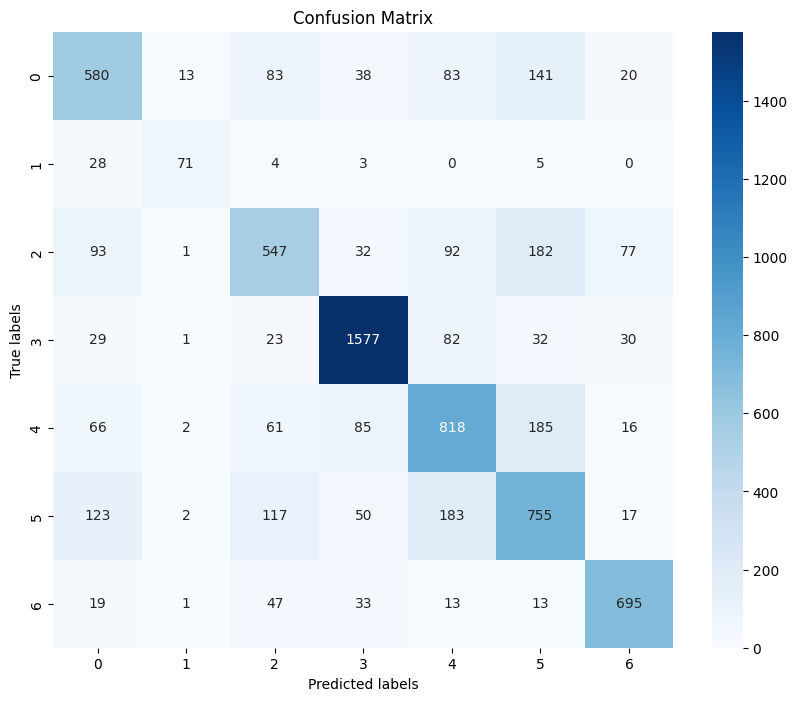

In [16]:
# confusion matrix on private and public test dataset for the best model: ViT_best
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm, trange

# creates a transformation pipeline
train_transform = Compose([
    Grayscale(num_output_channels=3),
    Resize(224),
    ToTensor(),
])

# ImageFolder returns a dataset object that can be directly passed to a DataLoade
train_data = ImageFolder(root=f"{data_dir_root}/train", transform=train_transform)
test_data = ImageFolder(root=f"{data_dir_root}/test", transform=train_transform)

# number of subprocesses set to 4
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, drop_last=True)

# pretrained vit_b_16
checkpoint_file_vit_b_16 = './drive/MyDrive/CS5100_Project_FacialEmotion_Lili/checkpoint/ckpt_epoch_19_pretrain_best.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# pretrained vit_b_16 model
model_vit_b_16 = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
# load vit_b_16 checkpoint
checkpoint_vit_b_16 = torch.load(checkpoint_file_vit_b_16, map_location='cpu')
model_vit_b_16.load_state_dict(checkpoint_vit_b_16['model_state_dict'])
model_vit_b_16.eval()
model_vit_b_16.to(device)

correct = 0
total = 0
all_preds = []
all_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(test_dataloader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model_vit_b_16(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.detach().cpu()
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()




## Inference

In [ ]:
id2label = {
    0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"
}
test_image = './drive/MyDrive/CS5100_Project_FacialEmotion_Lili/face_sad_crop.jpeg'
test_image = './drive/MyDrive/CS5100_Project_FacialEmotion_Lili/fer2013/test/sad/PrivateTest_831970.jpg'
image = Image.open(test_image)
# creates a transformation pipeline
infer_transform = Compose([
    Grayscale(num_output_channels=n_channels),
    Resize((48, 48)),
    ToTensor(),
])
image_x = infer_transform(image).unsqueeze(0)
predict = model(image_x.to(device))
_, predict = torch.max(predict.data, 1)
predict = predict.detach().cpu()
print(f"Predict={predict}-{id2label[predict[0].item()]}")

Predict=tensor([4])-Sad


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 58589319


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


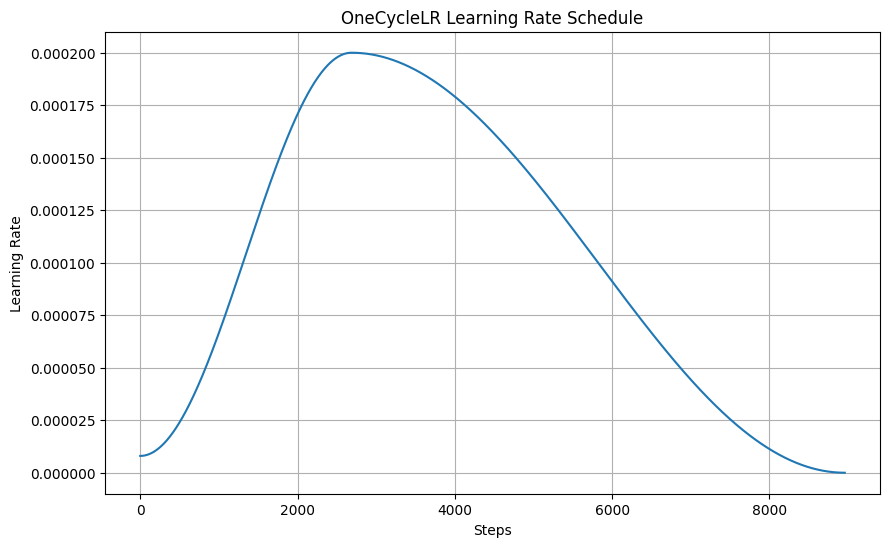

In [ ]:
N_EPOCHS = 20
LR = 2e-4
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                    steps_per_epoch=len(train_dataloader), epochs=N_EPOCHS)

# Track learning rates and steps
learning_rates = []
steps = []

# Simulate training loop
for epoch in range(N_EPOCHS):
    for step in range(len(train_dataloader)):
        # Update learning rate
        scheduler.step()
        lr = optimizer.param_groups[0]['lr']

        # Track learning rate and step
        learning_rates.append(lr)
        steps.append(epoch * len(train_dataloader) + step)

# Plot learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(steps, learning_rates)
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('OneCycleLR Learning Rate Schedule')
plt.grid(True)
plt.show()

## experiments need to do
1. data augmentation + 48x48 -> 96x96
2. training split into training (0.9) and validation (0.1) rather than using the test dataset
3. using pre-trained VIT checkpoint in image net
4. test there is any effect when channel = 3
5. test the standard ViT model: jax
6. adding the key point layer --- future work
7. visualization --- 1 learning rate scheduler and 1 result table
8. streamlit - add the best model with pre-trained weights
9. try more epochs

<table>
  <tr>
    <th>Configuration</th>
    <th>image size</th>
    <th>patch size</th>
    <th>num. of encoders</th>
    <th>num. of heads</th>
    <th>learning rate</th>
    <th>pre-trained model</th>
    <th>channel</th>
    <th>Evaluation accuracy on test dataset</th>
  </tr>
  <tr>
    <td>ViT embedding_dim = 768, without data augmentation</td>
    <td>48</td><td>8</td>
    <td>6</td><td>8</td>
    <td>fixed 2e-4</td><td>without</td>
    <td>1</td><td>45%</td>    
  </tr>
  <tr>
    <td>ViT embedding_dim = 768, without data augmentation</td>
    <td>48</td><td>8</td>
    <td>12</td><td>12</td>
    <td>fixed 2e-4</td><td>without</td>
    <td>1</td><td>45%</td>    
  </tr>
  <tr>
    <td>ViT embedding_dim = 768, with data augmentation</td>
    <td>48</td><td>8</td>
    <td>12</td><td>12</td>
    <td>OneCycle 2e-4</td><td>without</td>
    <td>1</td><td>49%</td>    
  </tr>
  <tr>
    <td>ViT embedding_dim = 768, with data augmentation</td>
    <td>224</td><td>16</td>
    <td>12</td><td>12</td>
    <td>OneCycle 2e-4</td><td>with vit_b_16</td>
    <td>3</td><td>70.35%</td>    
  </tr>
  <tr>
    <td>ViT embedding_dim = 768, with data augmentation</td>
    <td>224</td><td>16</td>
    <td>12</td><td>12</td>
    <td>OneCycle 2e-4</td><td>without</td>
    <td>3</td><td>51.3%</td>    
  </tr>
  <tr>
    <td>ViT embedding_dim = 768, with data augmentation</td>
    <td>224</td><td>16</td>
    <td>12</td><td>12</td>
    <td>OneCycle 2e-4</td><td>without</td>
    <td>1</td><td>51.65%</td>    
  </tr>
  <tr>
    <td>ViT embedding_dim = 768, with data augmentation</td>
    <td>96</td><td>8</td>
    <td>6</td><td>6</td>
    <td>OneCycle 2e-4</td><td>without</td>
    <td>1</td><td>51.79%</td>    
  </tr>
  <tr>
    <td>ViT embedding_dim = 768, with data augmentation</td>
    <td>48</td><td>8</td>
    <td>6</td><td>6</td>
    <td>OneCycle 2e-4</td><td>without</td>
    <td>1</td><td>50.66%</td>    
  </tr>
</table>

### Calculate parameter size

In [ ]:
# the most lightweight model
# define parameters
image_size = 48
patch_size = 8
num_classes=7
embedding_dim = 768
num_encoders = 6
num_heads = 6
dropout = 0.1
n_channels = 1

model = ViT(image_size=image_size, n_channels=n_channels, patch_size=patch_size, num_classes=num_classes,
        embedding_dim=embedding_dim, hidden_dim=embedding_dim*4, num_encoders=num_encoders,
        num_heads=num_heads, dropout=dropout)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 28895367


In [ ]:
# the best performance model
# define parameters
image_size = 224
patch_size = 16
num_classes=7
embedding_dim = 768
num_encoders = 12
num_heads = 12
dropout = 0.1
n_channels = 3

model = ViT(image_size=image_size, n_channels=n_channels, patch_size=patch_size, num_classes=num_classes,
        embedding_dim=embedding_dim, hidden_dim=embedding_dim*4, num_encoders=num_encoders,
        num_heads=num_heads, dropout=dropout)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 59254279
